In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import rel_entr
import networkx as nx
from sklearn.metrics import r2_score

import os
import json

In [2]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": 8,"axes.titlesize":8,"axes.labelsize":8, 
                                               "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 8
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#D55E00", "#0072B2", "#F0E442", "#56B4E9"]) 


In [3]:
pkn_path = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN_without_logic.gexf"
network = nx.read_gexf(pkn_path)

In [4]:
child_dict = {}
for n in network.nodes():
    child_dict[n] = [c for c in network.successors(n)]

    
child_dict = {k: f"{k}_inhbits_{'_'.join(v)}" for k, v in child_dict.items()}
child_dict

{'tgfa': 'tgfa_inhbits_ras_pi3k',
 'ras': 'ras_inhbits_mek12_pi3k',
 'pi3k': 'pi3k_inhbits_akt_map3k1',
 'igf1': 'igf1_inhbits_pi3k',
 'tnfa': 'tnfa_inhbits_pi3k_jnk12_map3k7',
 'jnk12': 'jnk12_inhbits_',
 'map3k7': 'map3k7_inhbits_p38_hsp27_mkk4_ikk',
 'il1a': 'il1a_inhbits_map3k1_map3k7',
 'map3k1': 'map3k1_inhbits_ikk_mkk4',
 'mek12': 'mek12_inhbits_erk12',
 'erk12': 'erk12_inhbits_hsp27',
 'hsp27': 'hsp27_inhbits_',
 'akt': 'akt_inhbits_ikk',
 'ikk': 'ikk_inhbits_ikb',
 'mkk4': 'mkk4_inhbits_p38_jnk12',
 'p38': 'p38_inhbits_hsp27',
 'ikb': 'ikb_inhbits_'}

In [5]:
folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Output/"
config_folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Configs/"

In [6]:
n_repeats = 5
n_settings = 425

perturb_data = []
unperturb_data = []

p_settings = np.empty(0)
p_repeats = np.empty(0)
p_nodes = np.empty(0)
p_k_values = np.empty(0)
p_d_values = np.empty(0)

up_settings = np.empty(0)
up_repeats = np.empty(0)
up_nodes = np.empty(0)
up_k_values = np.empty(0)
up_d_values = np.empty(0)

for i in range(n_settings):
    for j in range(n_repeats):
        perturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_perturbed.csv", index_col=1)
        perturb = perturb.rename(columns={"Unnamed: 0":"model"})
        perturb_data.append(perturb)
        
        unperturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_unperturbed.csv", index_col=1)
        unperturb = unperturb.rename(columns={"Unnamed: 0":"model"})
        unperturb_data.append(unperturb)
        
        with open(f"{config_folder}param_{i}_repeat_{j}_config.json", "r") as f:
            config = json.load(f)
        f.close()
        node = config["inhibited_node"]
        k_value = config["k_inhibition"]
        divide_value = config["divide_inhibition"]
        
        p_settings = np.hstack([p_settings, [i]*len(perturb)])
        p_repeats = np.hstack([p_repeats, [j]*len(perturb)])
        p_nodes = np.hstack([p_nodes, [node]*len(perturb)])
        p_k_values = np.hstack([p_k_values, [k_value]*len(perturb)])
        p_d_values = np.hstack([p_d_values, [divide_value]*len(perturb)])
    
        up_settings = np.hstack([up_settings, [i]*len(unperturb)])
        up_repeats = np.hstack([up_repeats, [j]*len(unperturb)])
        up_nodes = np.hstack([up_nodes, [node]*len(unperturb)])
        up_k_values = np.hstack([up_k_values, [k_value]*len(unperturb)])
        up_d_values = np.hstack([up_d_values, [divide_value]*len(unperturb)])

In [7]:
config

{'pkn_path': '/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif',
 'train_size': 10000,
 'test_size': 1000,
 'k_inhibition': -0.5,
 'divide_inhibition': 50,
 'train_frac': 0.7,
 'BFN_training_params': {'epochs': 500,
  'batch_size': 500,
  'learning_rate': 0.001,
  'tensors_to_cuda': False},
 'out_dir': '/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Output/param_424_repeat_4',
 'experiment_name': 'BFN_perturb',
 'param_setting': 424,
 'inhibited_node': 'hsp27',
 'repeat': 4}

In [8]:
perturb_data = pd.concat(perturb_data)
unperturb_data = pd.concat(unperturb_data)
perturb_data["setting"] = p_settings
perturb_data["repeat"] = p_repeats
perturb_data["inhibited_node"] = p_nodes
perturb_data["k_value"] = p_k_values
perturb_data["d_value"] = p_d_values

unperturb_data["setting"] = up_settings
unperturb_data["repeat"] = up_repeats
unperturb_data["inhibited_node"] = up_nodes
unperturb_data["k_value"] = up_k_values
unperturb_data["d_value"] = up_d_values


In [9]:
perturb_data = perturb_data.rename(columns={"node": "inhibited_node"})
unperturb_data = unperturb_data.rename(columns={"node": "inhibited_node"})

In [10]:
setting_to_node = perturb_data[["setting", 
                                "inhibited_node"]].drop_duplicates().set_index("setting").to_dict()["inhibited_node"]
output_markers = [c for c in perturb_data.columns if c not in ["setting", 
                                                               "inhibited_node",
                                                               "model", "repeat",
                                                               "k_value", 
                                                               "d_value"]]
markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

In [11]:
perturb_data.isna().sum()

model             0
mek12             0
erk12             0
mkk4              0
jnk12             0
ikk               0
ikb               0
ras               0
map3k7            0
pi3k              0
map3k1            0
akt               0
p38               0
hsp27             0
setting           0
repeat            0
inhibited_node    0
k_value           0
d_value           0
dtype: int64

In [12]:
def compute_MSE(data, true_model_name: str):
    true = data[data["model"]==true_model_name]
    true = true.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    true["repeat"] = 0 # So that repeat doesn't get lost when x-true. This doesn't cancel out the different repeats
    data = data.groupby("model").apply(lambda x: ((x-true)**2).groupby("repeat").mean())
    data = data.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    data = data.reset_index("model", drop=False)
    
    return data

def compute_KL(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([rel_entr(true[m], x[m]).sum() for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data

def compute_R2(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([r2_score(true[m], x[m]) for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data

In [13]:
perturb_MSE = perturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
unperturb_MSE = unperturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_no_pertrub_true").reset_index()

perturb_KL = perturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node", "repeat"]).apply(compute_KL, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1)
unperturb_KL = perturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node", "repeat"]).apply(compute_KL, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1)

perturb_R2 = perturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1)
unperturb_R2 = unperturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_5", axis=1)


In [14]:
perturb_MSE

,setting,k_value,d_value,inhibited_node,repeat,model,akt,erk12,hsp27,ikb,ikk,jnk12,map3k1,map3k7,mek12,mkk4,p38,pi3k,ras
0,0.0,-100.0,10.0,mek12,0.0,student_division_random_input,0.141854,0.006227,0.432763,0.297341,0.226301,0.411870,0.313856,0.176915,0.302040,0.389842,0.415548,0.085378,0.233504
1,0.0,-100.0,10.0,mek12,1.0,student_division_random_input,0.098105,0.005861,0.472788,0.280497,0.211971,0.427671,0.273910,0.213150,0.365830,0.396435,0.449507,0.068144,0.292430
2,0.0,-100.0,10.0,mek12,4.0,student_division_random_input,0.110932,0.039814,0.447558,0.315236,0.240870,0.429210,0.273421,0.185174,0.350987,0.375936,0.425788,0.081380,0.289142
3,0.0,-100.0,10.0,mek12,9.0,student_division_random_input,0.111497,0.003226,0.428712,0.261508,0.211080,0.418691,0.325011,0.176166,0.288498,0.385744,0.419432,0.090201,0.220235
4,0.0,-100.0,10.0,mek12,16.0,student_division_random_input,0.101557,0.005310,0.433259,0.281513,0.246918,0.410504,0.281710,0.181391,0.314034,0.354603,0.406970,0.088757,0.259735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14870,424.0,-0.5,50.0,hsp27,0.0,untrained_division_same_input,0.002133,0.081711,0.029984,0.066225,0.028354,0.033509,0.010216,0.012688,0.070244,0.011597,0.018984,0.001479,0.036136
14871,424.0,-0.5,50.0,hsp27,1.0,untrained_division_same_input,0.002804,0.015122,0.030881,0.010747,0.005938,0.025444,0.010244,0.002691,0.012918,0.012352,0.014791,0.004586,0.006650
14872,424.0,-0.5,50.0,hsp27,4.0,untrained_division_same_input,0.002242,0.007150,0.032400,0.016310,0.008659,0.005686,0.004014,0.008875,0.002186,0.012198,0.025259,0.000582,0.001970
14873,424.0,-0.5,50.0,hsp27,9.0,untrained_division_same_input,0.008246,0.000335,0.043836,0.051818,0.027371,0.040533,0.007830,0.010647,0.000193,0.022146,0.029194,0.003508,0.002710


# Select parameter settings
Based on mean MSE per node for the student with same input. k-value of -100 is clearly better, the d-value seems to have less effect, we select a d-value of 20

In [15]:
avg_perturb_MSE = perturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_unperturb_MSE = unperturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_perturb_KL = perturb_KL.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_unperturb_KL = unperturb_KL.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_perturb_R2 = perturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_unperturb_R2 = unperturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()

plt_perturb_mMSE = avg_perturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")
plt_unperturb_mMSE = avg_unperturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")
plt_perturb_mKL = avg_perturb_KL.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")
plt_unperturb_mKL = avg_unperturb_KL.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")
plt_perturb_mR2 = avg_perturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")
plt_unperturb_mR2 = avg_unperturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="mMSE", var_name="node")


plt_perturb_mMSE = plt_perturb_mMSE.sample(n=len(plt_perturb_mMSE))
plt_unperturb_mMSE = plt_unperturb_mMSE.sample(n=len(plt_unperturb_mMSE))
plt_perturb_mKL = plt_perturb_mKL.sample(n=len(plt_perturb_mKL))
plt_unperturb_mKL = plt_unperturb_mKL.sample(n=len(plt_unperturb_mKL))
plt_perturb_mR2 = plt_perturb_mR2.sample(n=len(plt_perturb_mR2))
plt_unperturb_mR2 = plt_unperturb_mR2.sample(n=len(plt_unperturb_mR2))

In [16]:
plt_perturb_mMSE

,setting,k_value,d_value,inhibited_node,model,node,mMSE
3801,118.0,-1.0,20.0,ras,student_division_random_input,erk12,3.084435e-01
37125,203.0,-1.0,30.0,ras,teacher_k_inhibition_true,ras,0.000000e+00
1585,226.0,-10.0,30.0,map3k1,teacher_division_same_input,akt,0.000000e+00
29074,328.0,-1.0,40.0,akt,teacher_division_same_input,mkk4,0.000000e+00
29019,320.0,-100.0,40.0,tnfa,teacher_k_inhibition_true,mkk4,0.000000e+00
...,...,...,...,...,...,...,...
23157,333.0,-1.0,40.0,p38,student_division_same_input,map3k7,9.069285e-08
3550,82.0,-5.0,10.0,hsp27,student_division_same_input,erk12,1.220242e-10
37115,202.0,-5.0,30.0,ras,student_division_same_input,ras,1.210069e-09
34938,316.0,-10.0,40.0,tgfa,student_division_same_input,pi3k,3.689975e-05


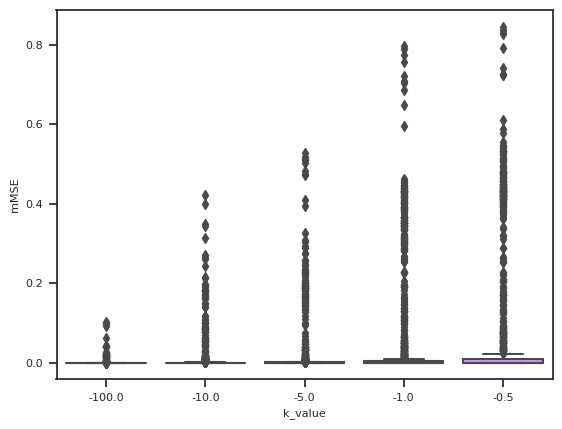

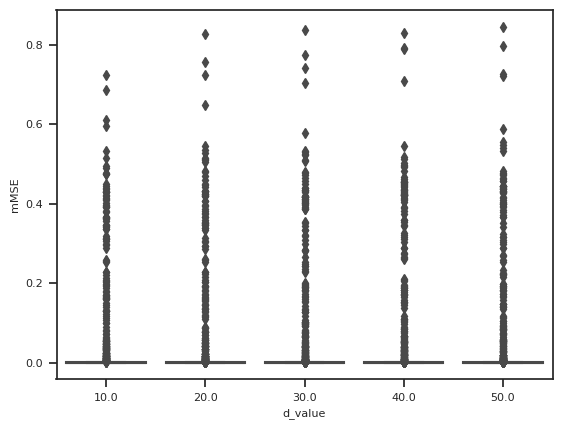

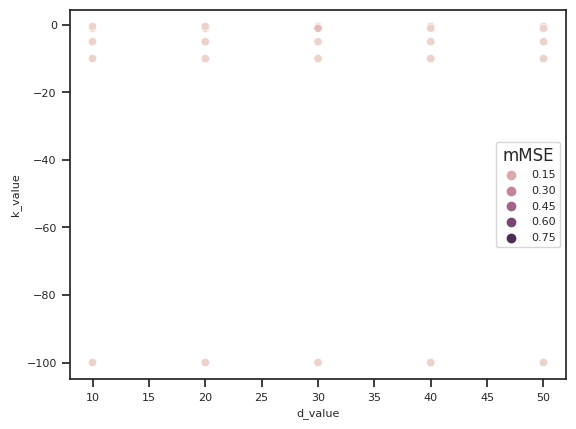

In [32]:
sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="k_value", y='mMSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_k.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", y='mMSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", hue='mMSE', y="k_value")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_k_d.pdf", bbox_inches="tight")
plt.show()

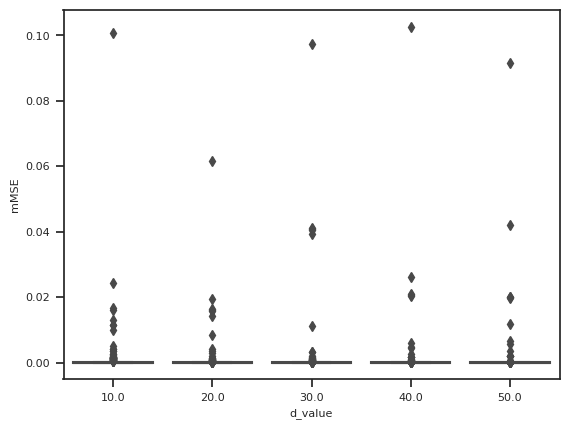

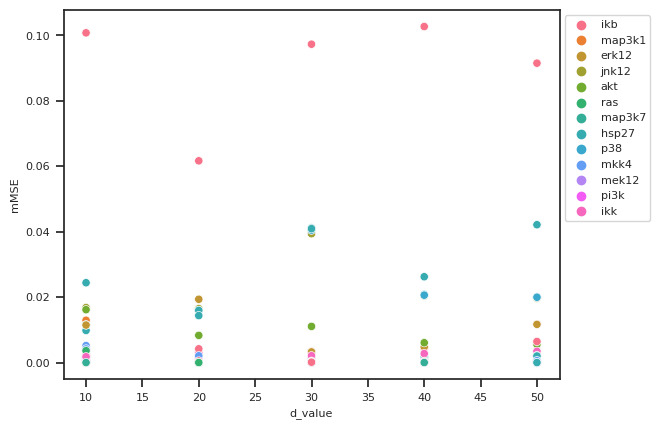

In [33]:
sns.boxplot(data=plt_perturb_mMSE[(plt_perturb_mMSE["model"]=="student_division_same_input")&
                                 (plt_perturb_mMSE["k_value"]==-100)], x="d_value", y='mMSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_student_div_k-100_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mMSE[(plt_perturb_mMSE["model"]=="student_division_same_input")&
                                 (plt_perturb_mMSE["k_value"]==-100)], x="d_value", y='mMSE', hue="node")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_student_div_k-100_params_mMSE_d_node_color.pdf", bbox_inches="tight")
plt.show()


# Analyze selected result

In [19]:
perturb_MSE = perturb_MSE[(perturb_MSE["d_value"]==20)&
                           (perturb_MSE["k_value"]==-100)]
unperturb_MSE = unperturb_MSE[(unperturb_MSE["d_value"]==20)& 
                               (unperturb_MSE["k_value"]==-100)]

perturb_KL = perturb_KL[(perturb_KL["d_value"]==20)& 
                        (perturb_KL["k_value"]==-100)]
unperturb_KL = unperturb_KL[(unperturb_KL["d_value"]==20)& 
                            (unperturb_KL["k_value"]==-100)]

perturb_R2 = perturb_R2[(perturb_R2["d_value"]==20)& 
                        (perturb_R2["k_value"]==-100)]
unperturb_R2 = unperturb_R2[(unperturb_R2["d_value"]==20)& 
                            (unperturb_R2["k_value"]==-100)]

perturb_MSE = perturb_MSE.drop(["k_value", "d_value"], axis=1)
unperturb_MSE = unperturb_MSE.drop(["k_value", "d_value"], axis=1)
perturb_KL = perturb_KL.drop(["k_value", "d_value"], axis=1)
unperturb_KL = unperturb_KL.drop(["k_value", "d_value"], axis=1)
perturb_R2 = perturb_R2.drop(["k_value", "d_value"], axis=1)
unperturb_R2 = unperturb_R2.drop(["k_value", "d_value"], axis=1)

In [20]:
perturb_R2

,setting,repeat,inhibited_node,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27
2975,85.0,0.0,mek12,student_division_random_input,-1.332247,-1.039160,-0.920203,-0.942379,-0.747758,-0.836575,-1.408332,-0.859244,-1.096611,-0.906279,-1.036776,-0.959886,-0.976264
2976,85.0,0.0,mek12,student_division_same_input,1.000000,-0.963035,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999982,1.000000,0.999992,1.000000,0.999997
2977,85.0,0.0,mek12,teacher_division_random_input,-1.050632,-0.894484,-1.026691,-1.017308,-1.087505,-1.070506,-1.058159,-1.035464,-1.068092,-1.036908,-1.004840,-1.017176,-1.019491
2978,85.0,0.0,mek12,teacher_division_same_input,1.000000,-0.963035,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999997
2979,85.0,0.0,mek12,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,165.0,4.0,hsp27,teacher_division_random_input,-0.875382,-0.869548,-0.972769,-0.971964,-0.974341,-1.007273,-0.875247,-1.019187,-0.910384,-0.977358,-0.903638,-0.977491,-0.967781
5806,165.0,4.0,hsp27,teacher_division_same_input,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5807,165.0,4.0,hsp27,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5808,165.0,4.0,hsp27,untrained_division_random_input,-1.187587,-1.242087,-0.872390,-0.912257,-0.711047,-0.781950,-1.037147,-0.892085,-0.790768,-0.973593,-0.601598,-0.940606,-0.935448


# R2, so same inputs

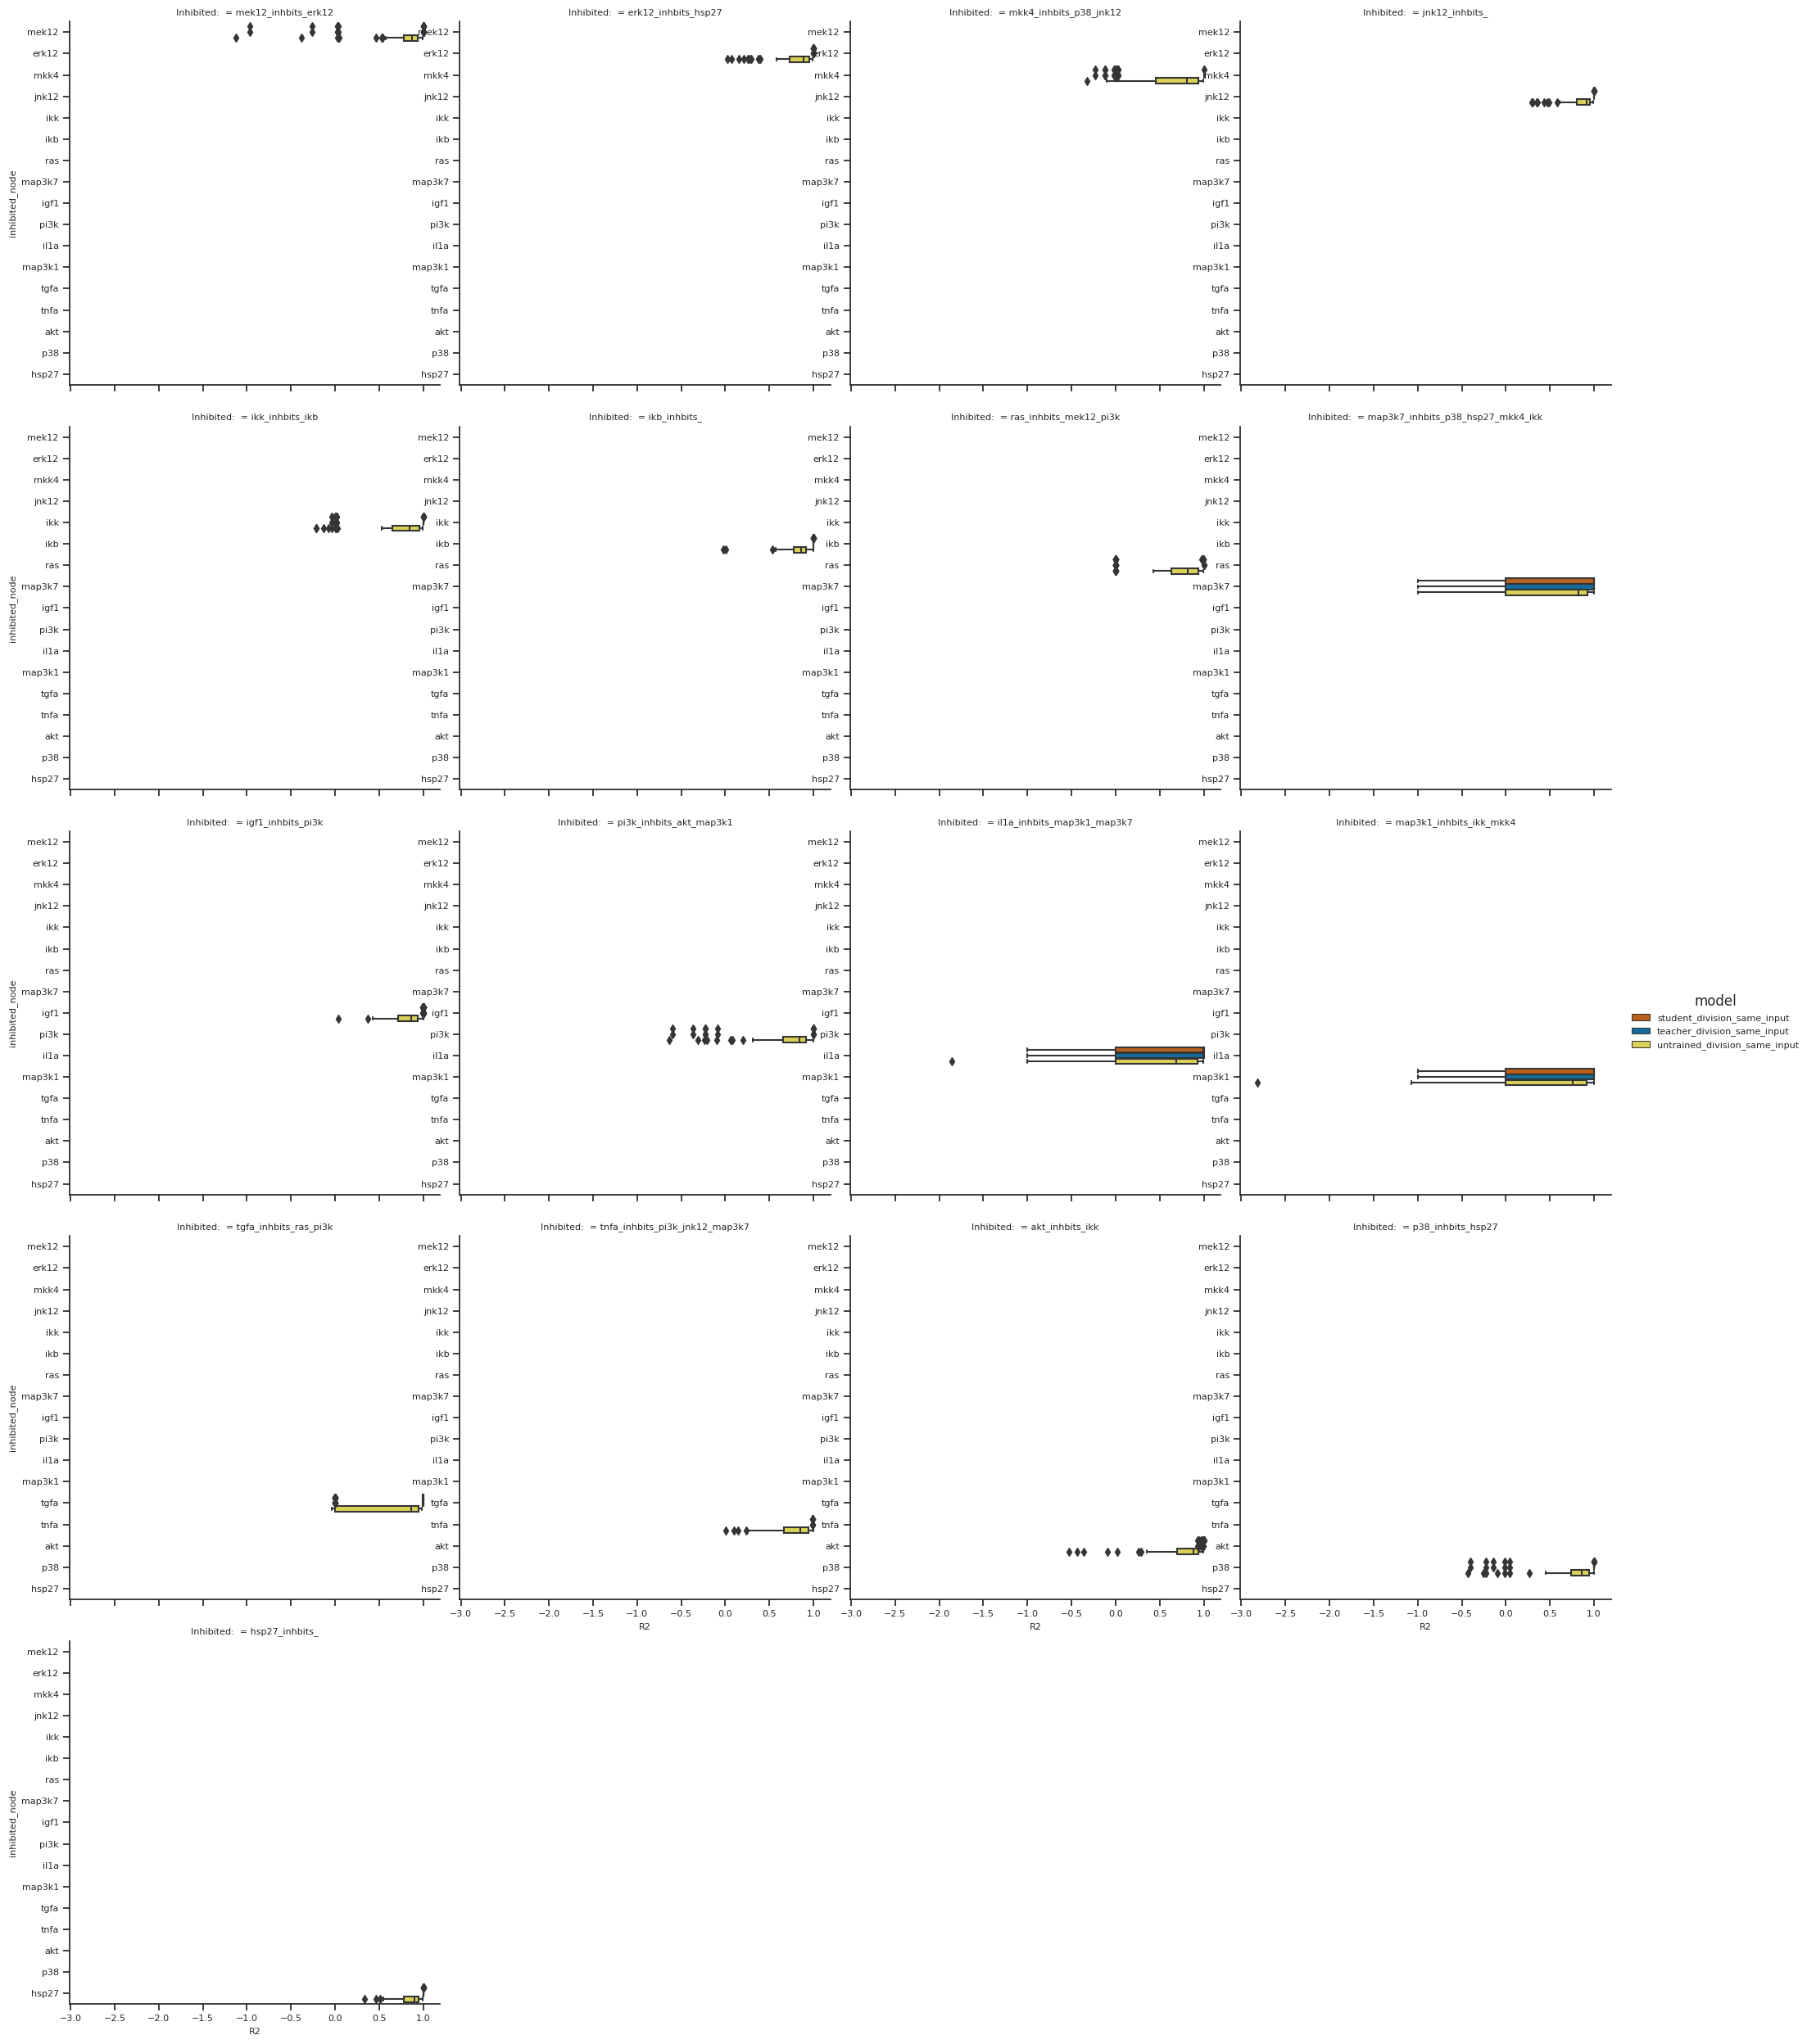

In [21]:
plt_data = perturb_R2[["same" in m for m in perturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
temp = plt_data.copy()
temp.loc[temp["R2"]<-10, "R2"] = -1
g = sns.catplot(data=temp, y="inhibited_node", x="R2", col="Inhibited: ", col_wrap=4, kind="box", hue="model")#.set(xscale='symlog')
for ax in g.axes.flatten():
    ax.tick_params(labelleft=True)
    
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs.pdf", bbox_inches="tight")
plt.show()

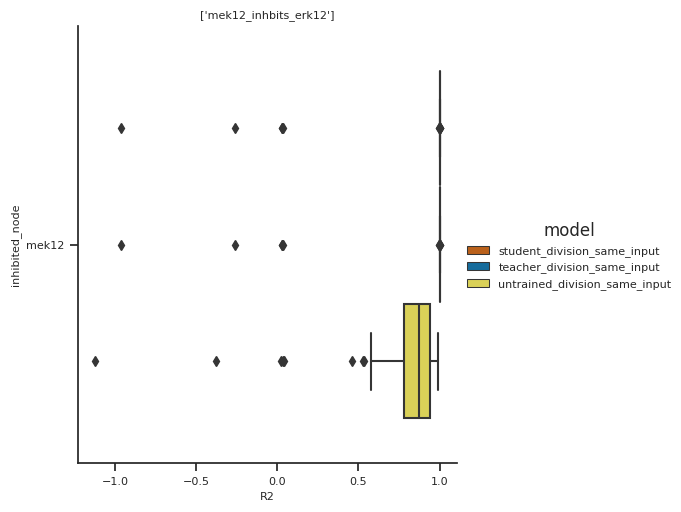

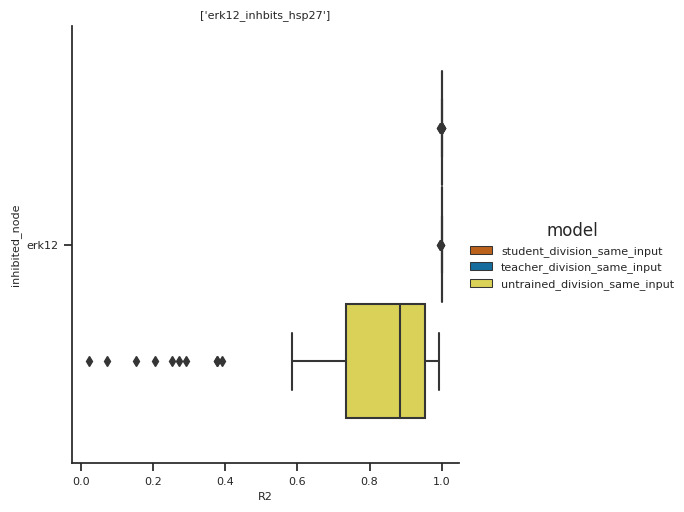

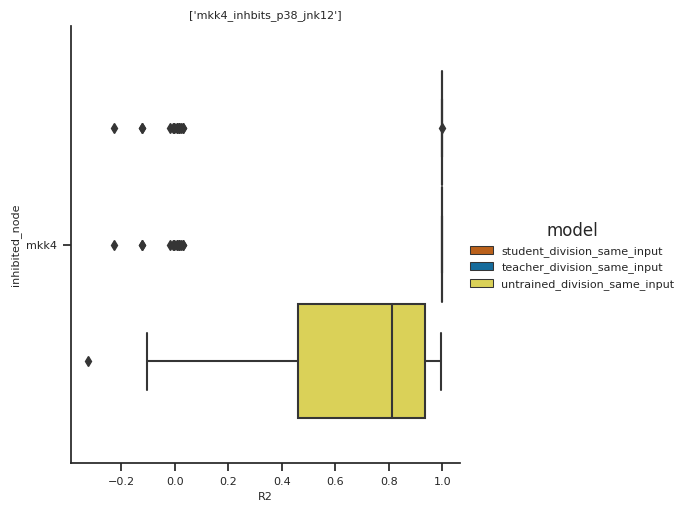

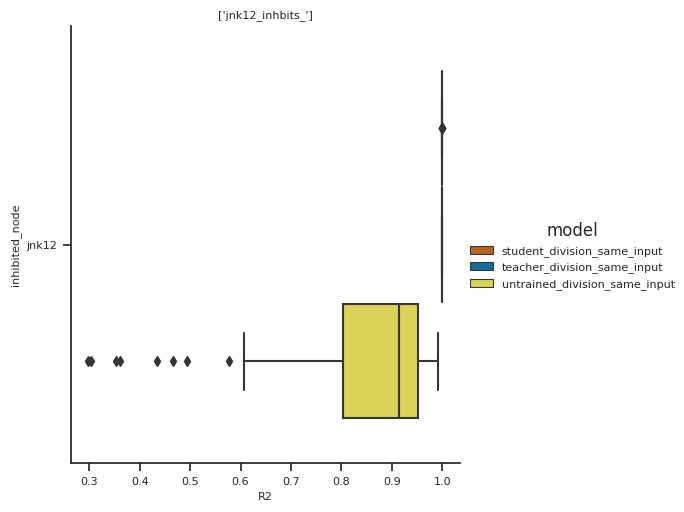

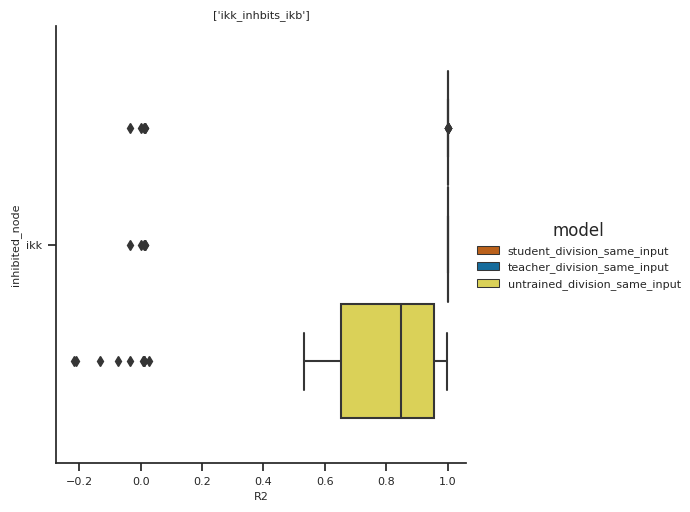

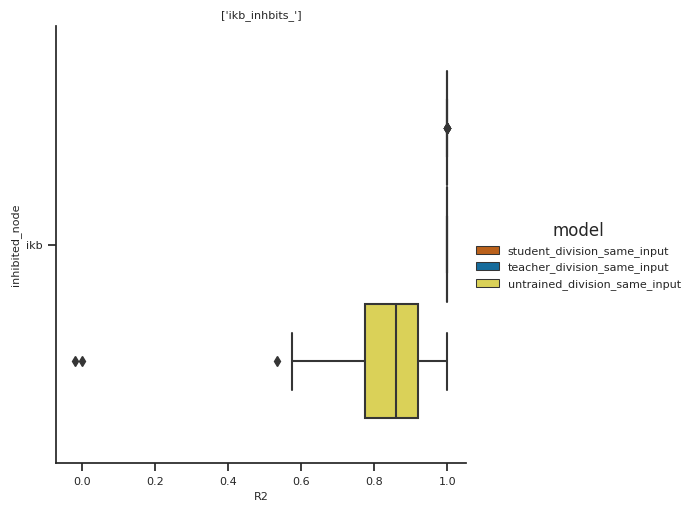

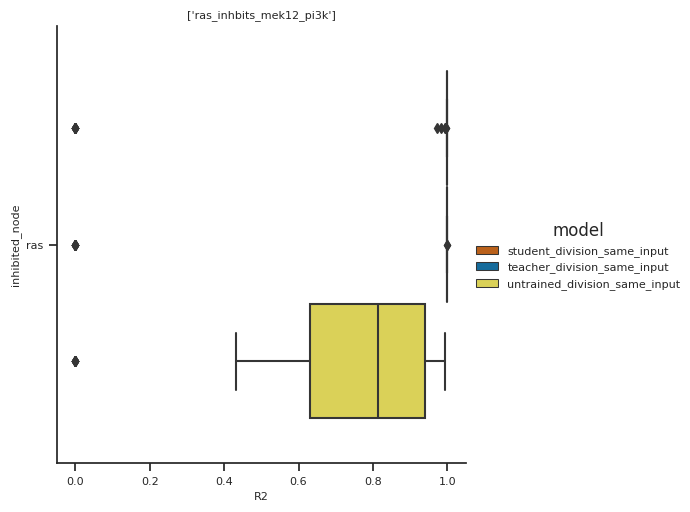

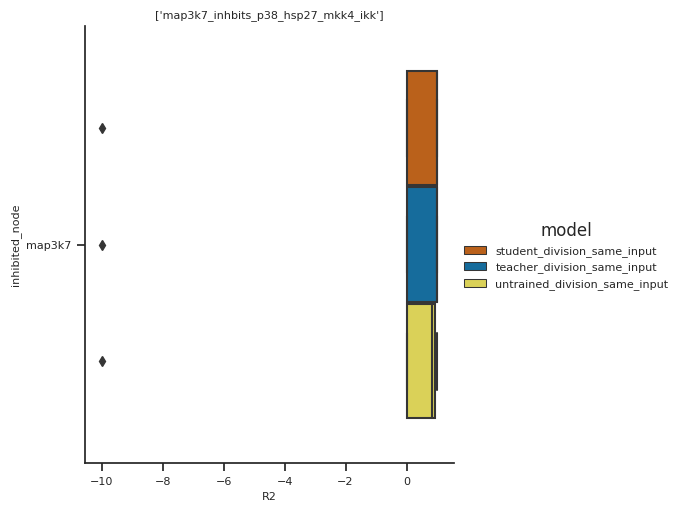

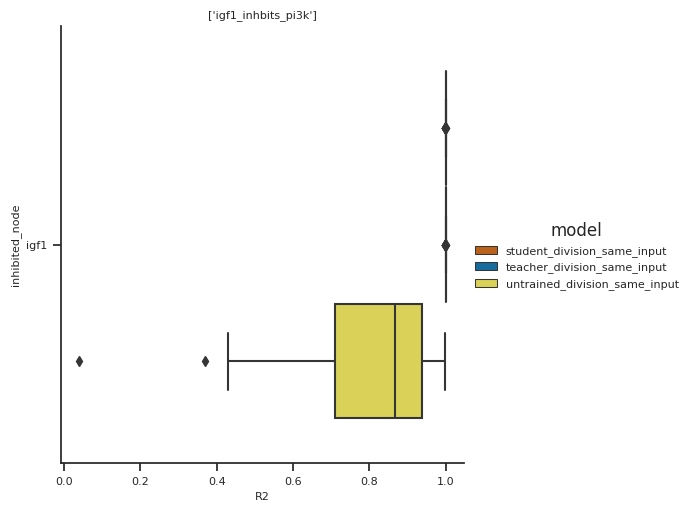

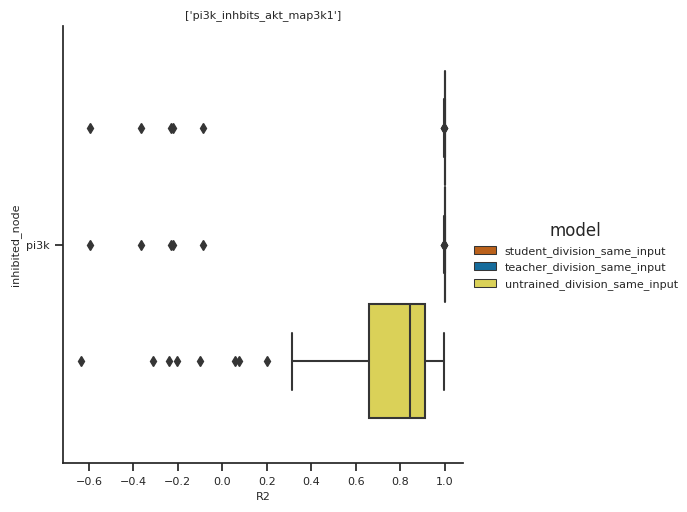

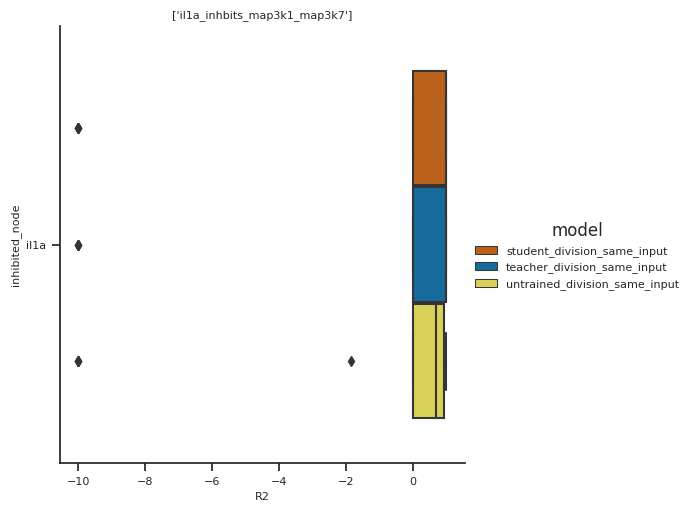

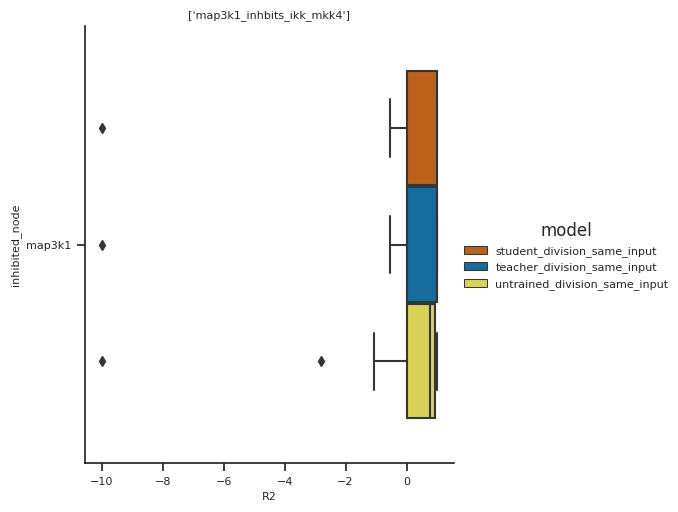

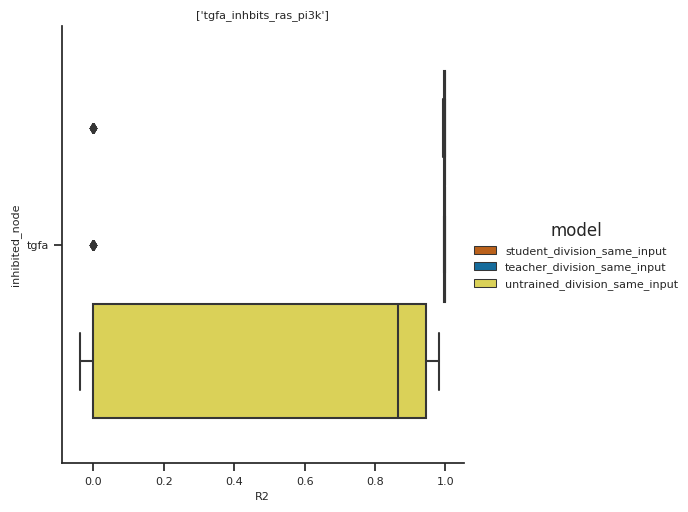

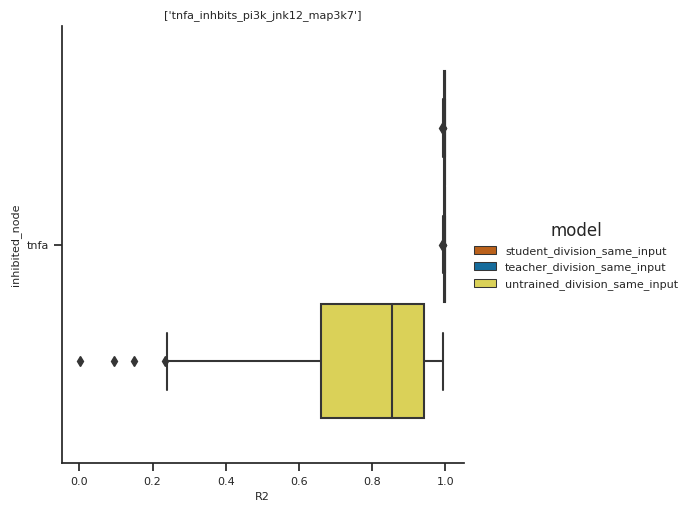

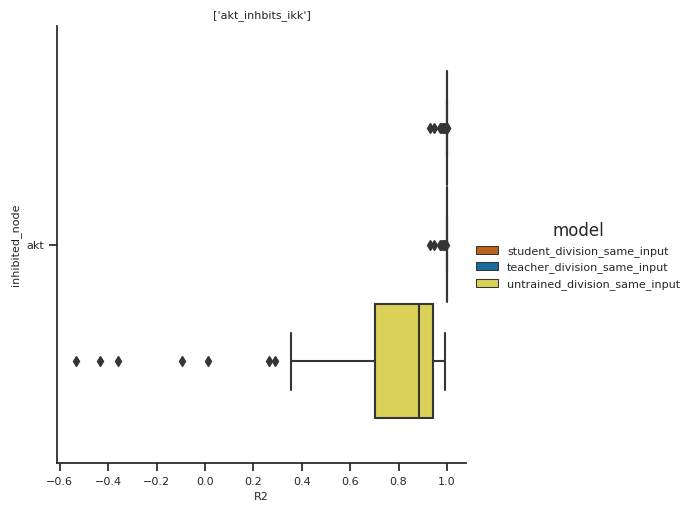

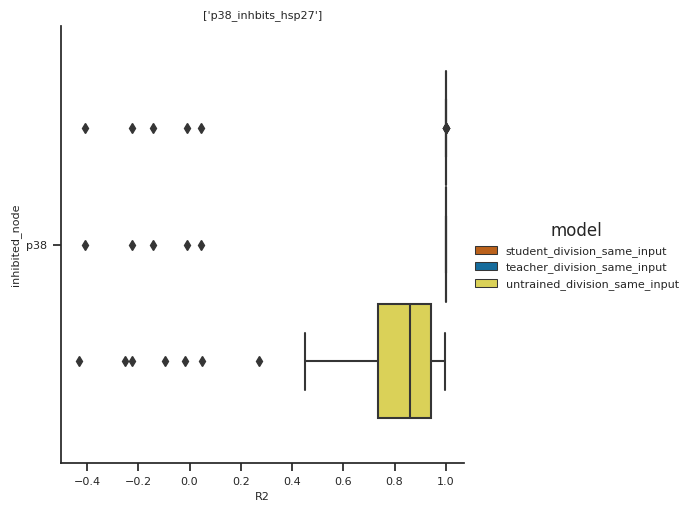

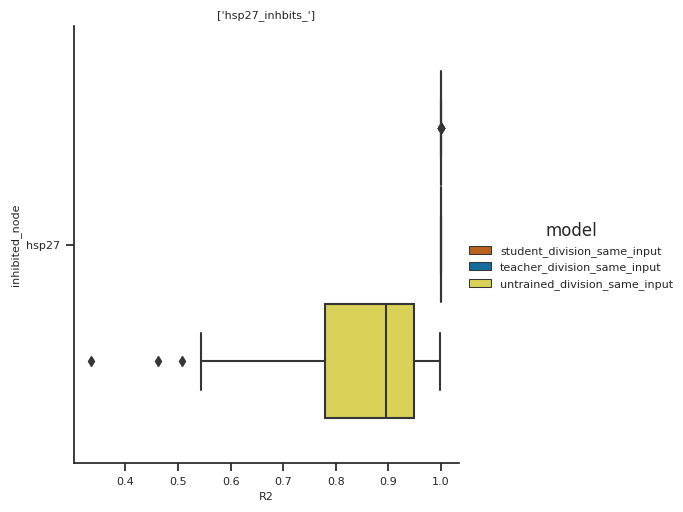

In [22]:
for n in plt_data["inhibited_node"].unique():
    temp = plt_data[plt_data["inhibited_node"]==n]
    temp.loc[temp["R2"]<-10, "R2"] = -10
    sns.catplot(data=temp, y="inhibited_node", x="R2", kind="box", hue="model")
    plt.title(temp["Inhibited: "].unique())
    plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_{n}_inhibited.pdf", bbox_inches="tight")
    plt.show()

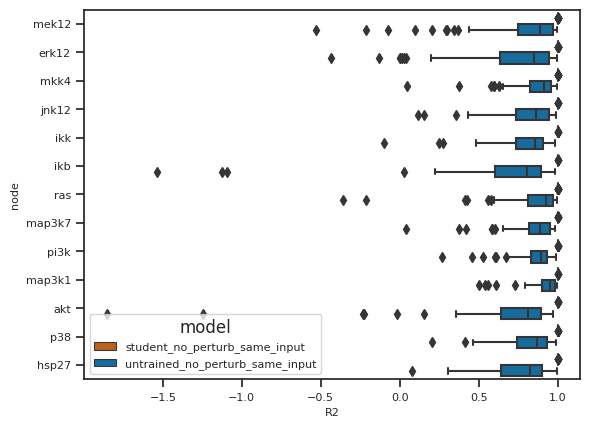

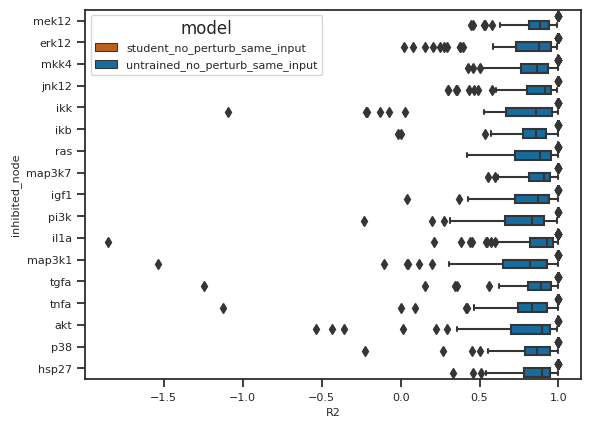

In [23]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_R2[["same" in m for m in unperturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
sns.boxplot(data = plt_data, y="node", x="R2", hue="model")
plt.show()

sns.boxplot(data = plt_data, y="inhibited_node", x="R2", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_no_perturbation.pdf", bbox_inches="tight")
plt.show()


# KL div, so unmatched inputs

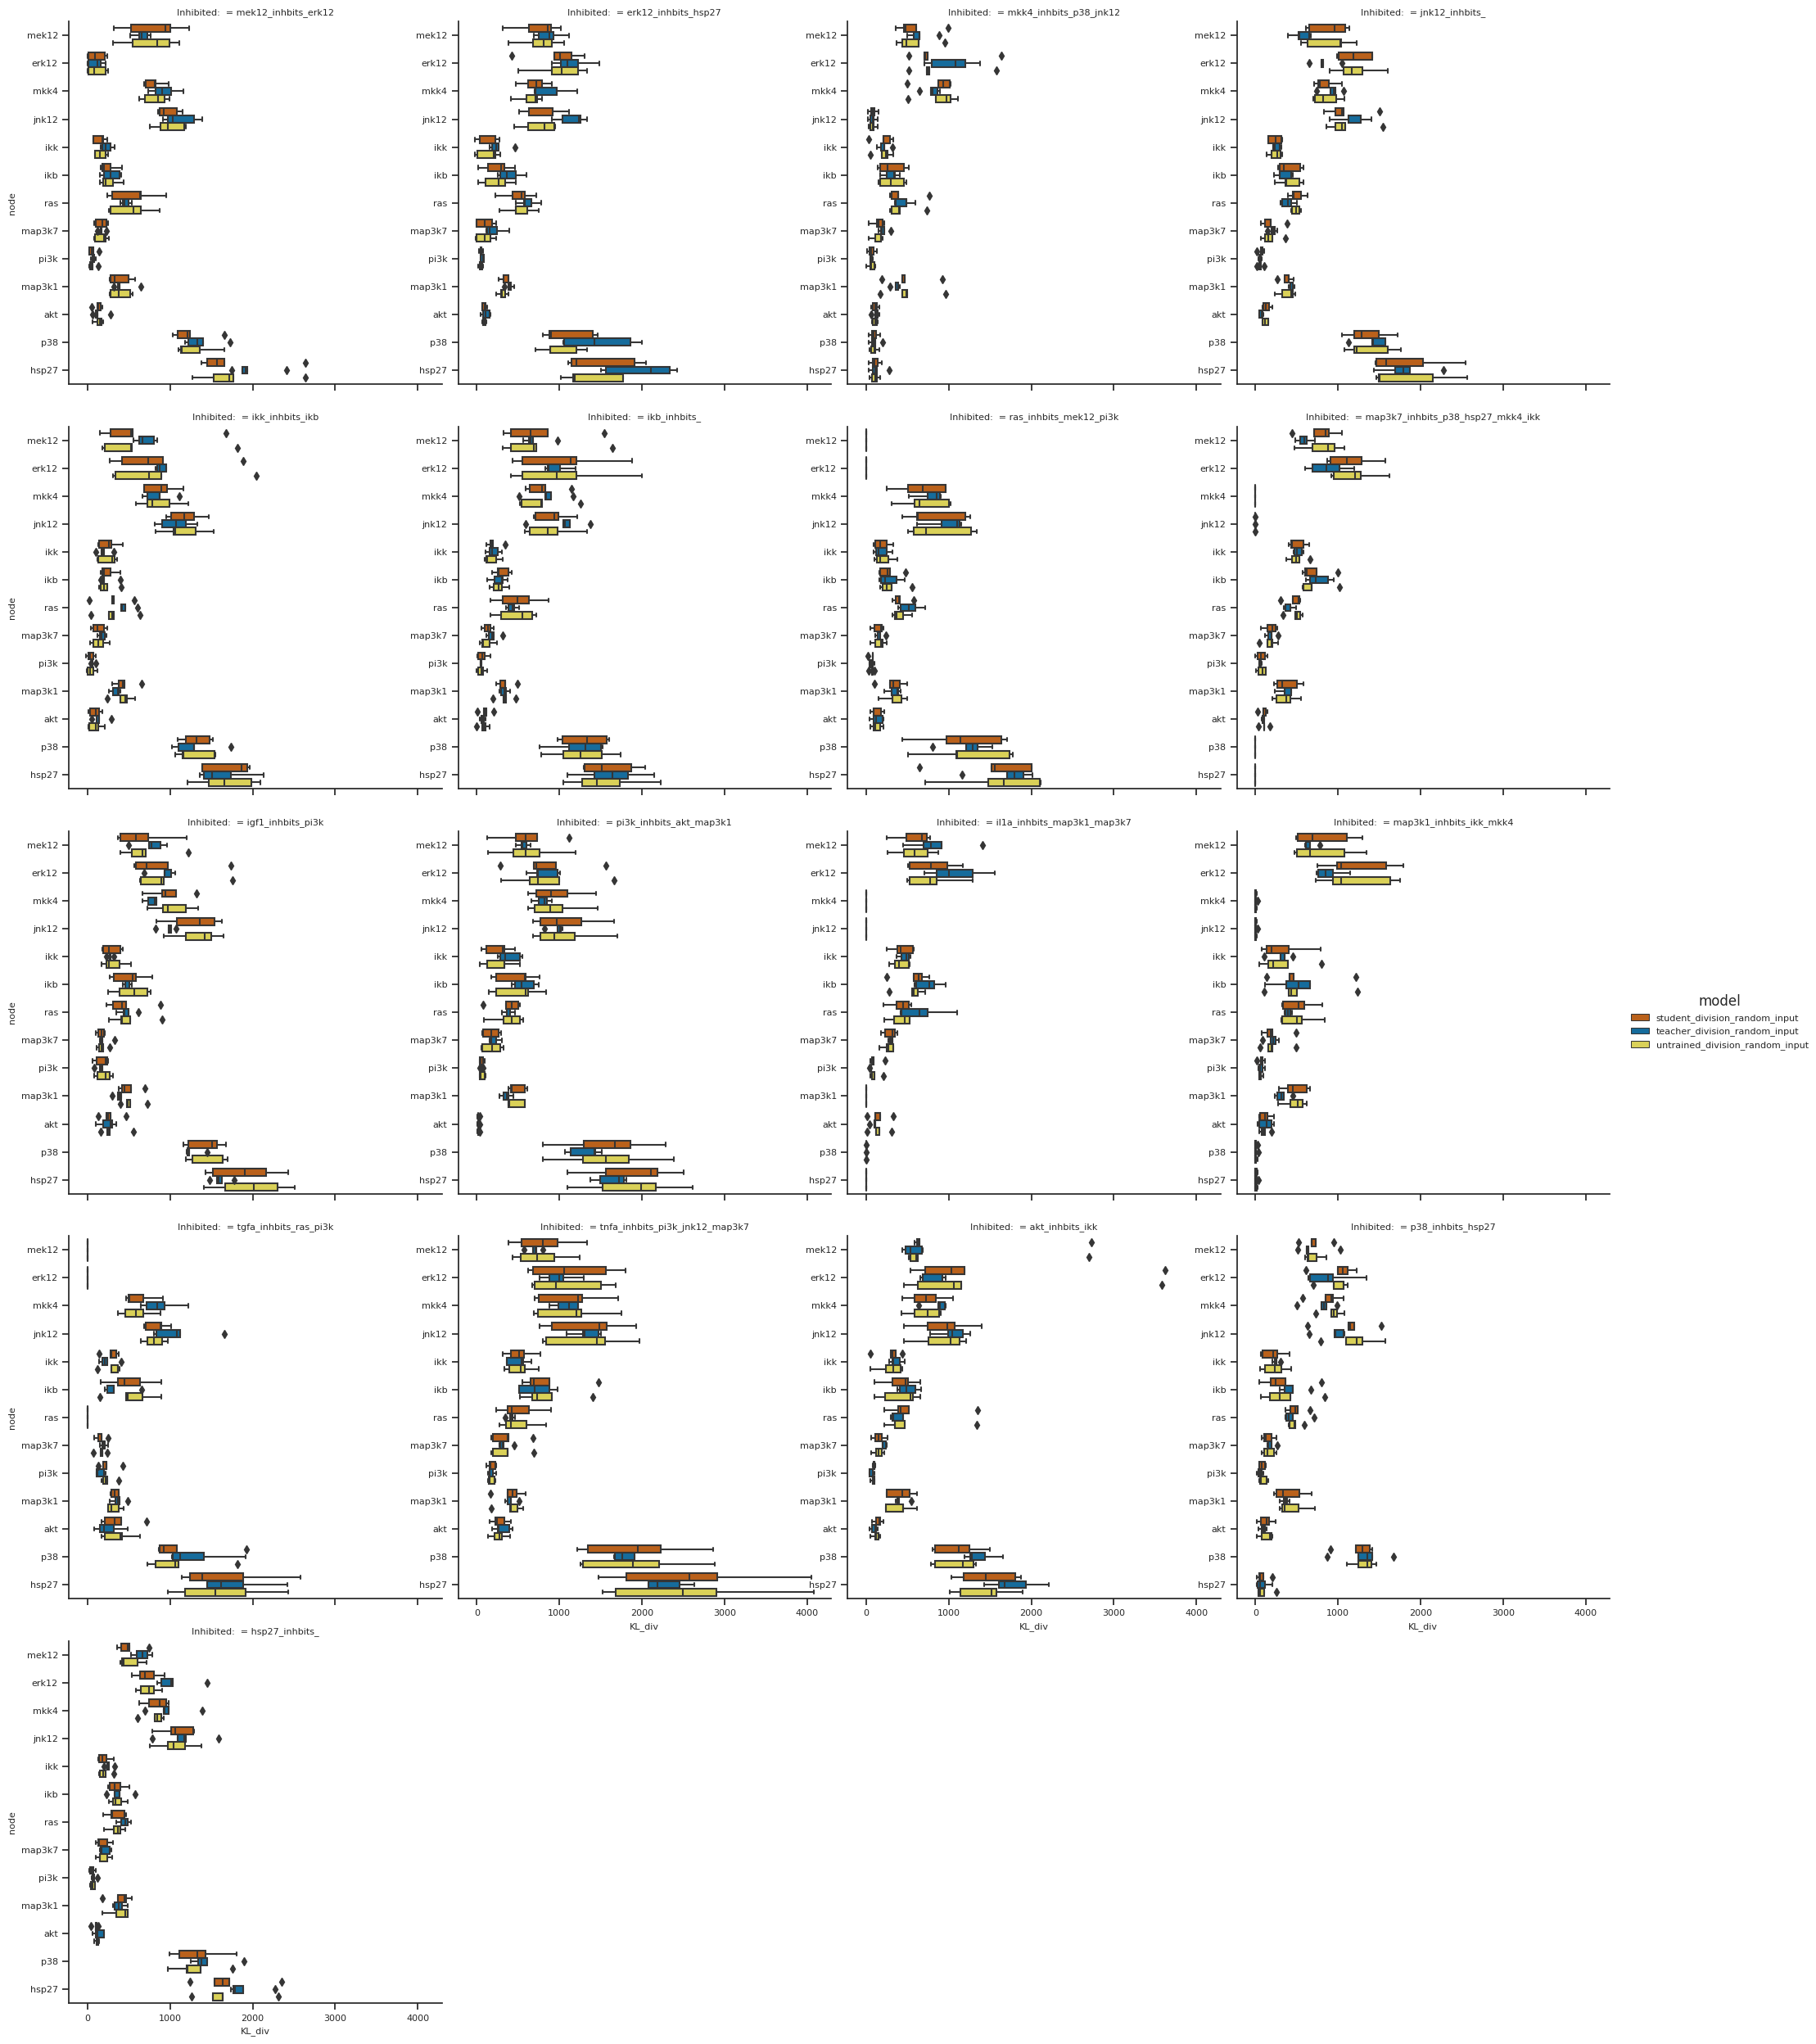

In [24]:
plt_data = perturb_KL[["random" in m for m in perturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="KL_div")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="KL_div", col="Inhibited: ", col_wrap=4, kind="box", hue="model")
for ax in g.axes.flatten():
    ax.tick_params(labelleft=True)
    
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_KL_random_inputs.pdf", bbox_inches="tight")
plt.show()

## KL on matched inputs

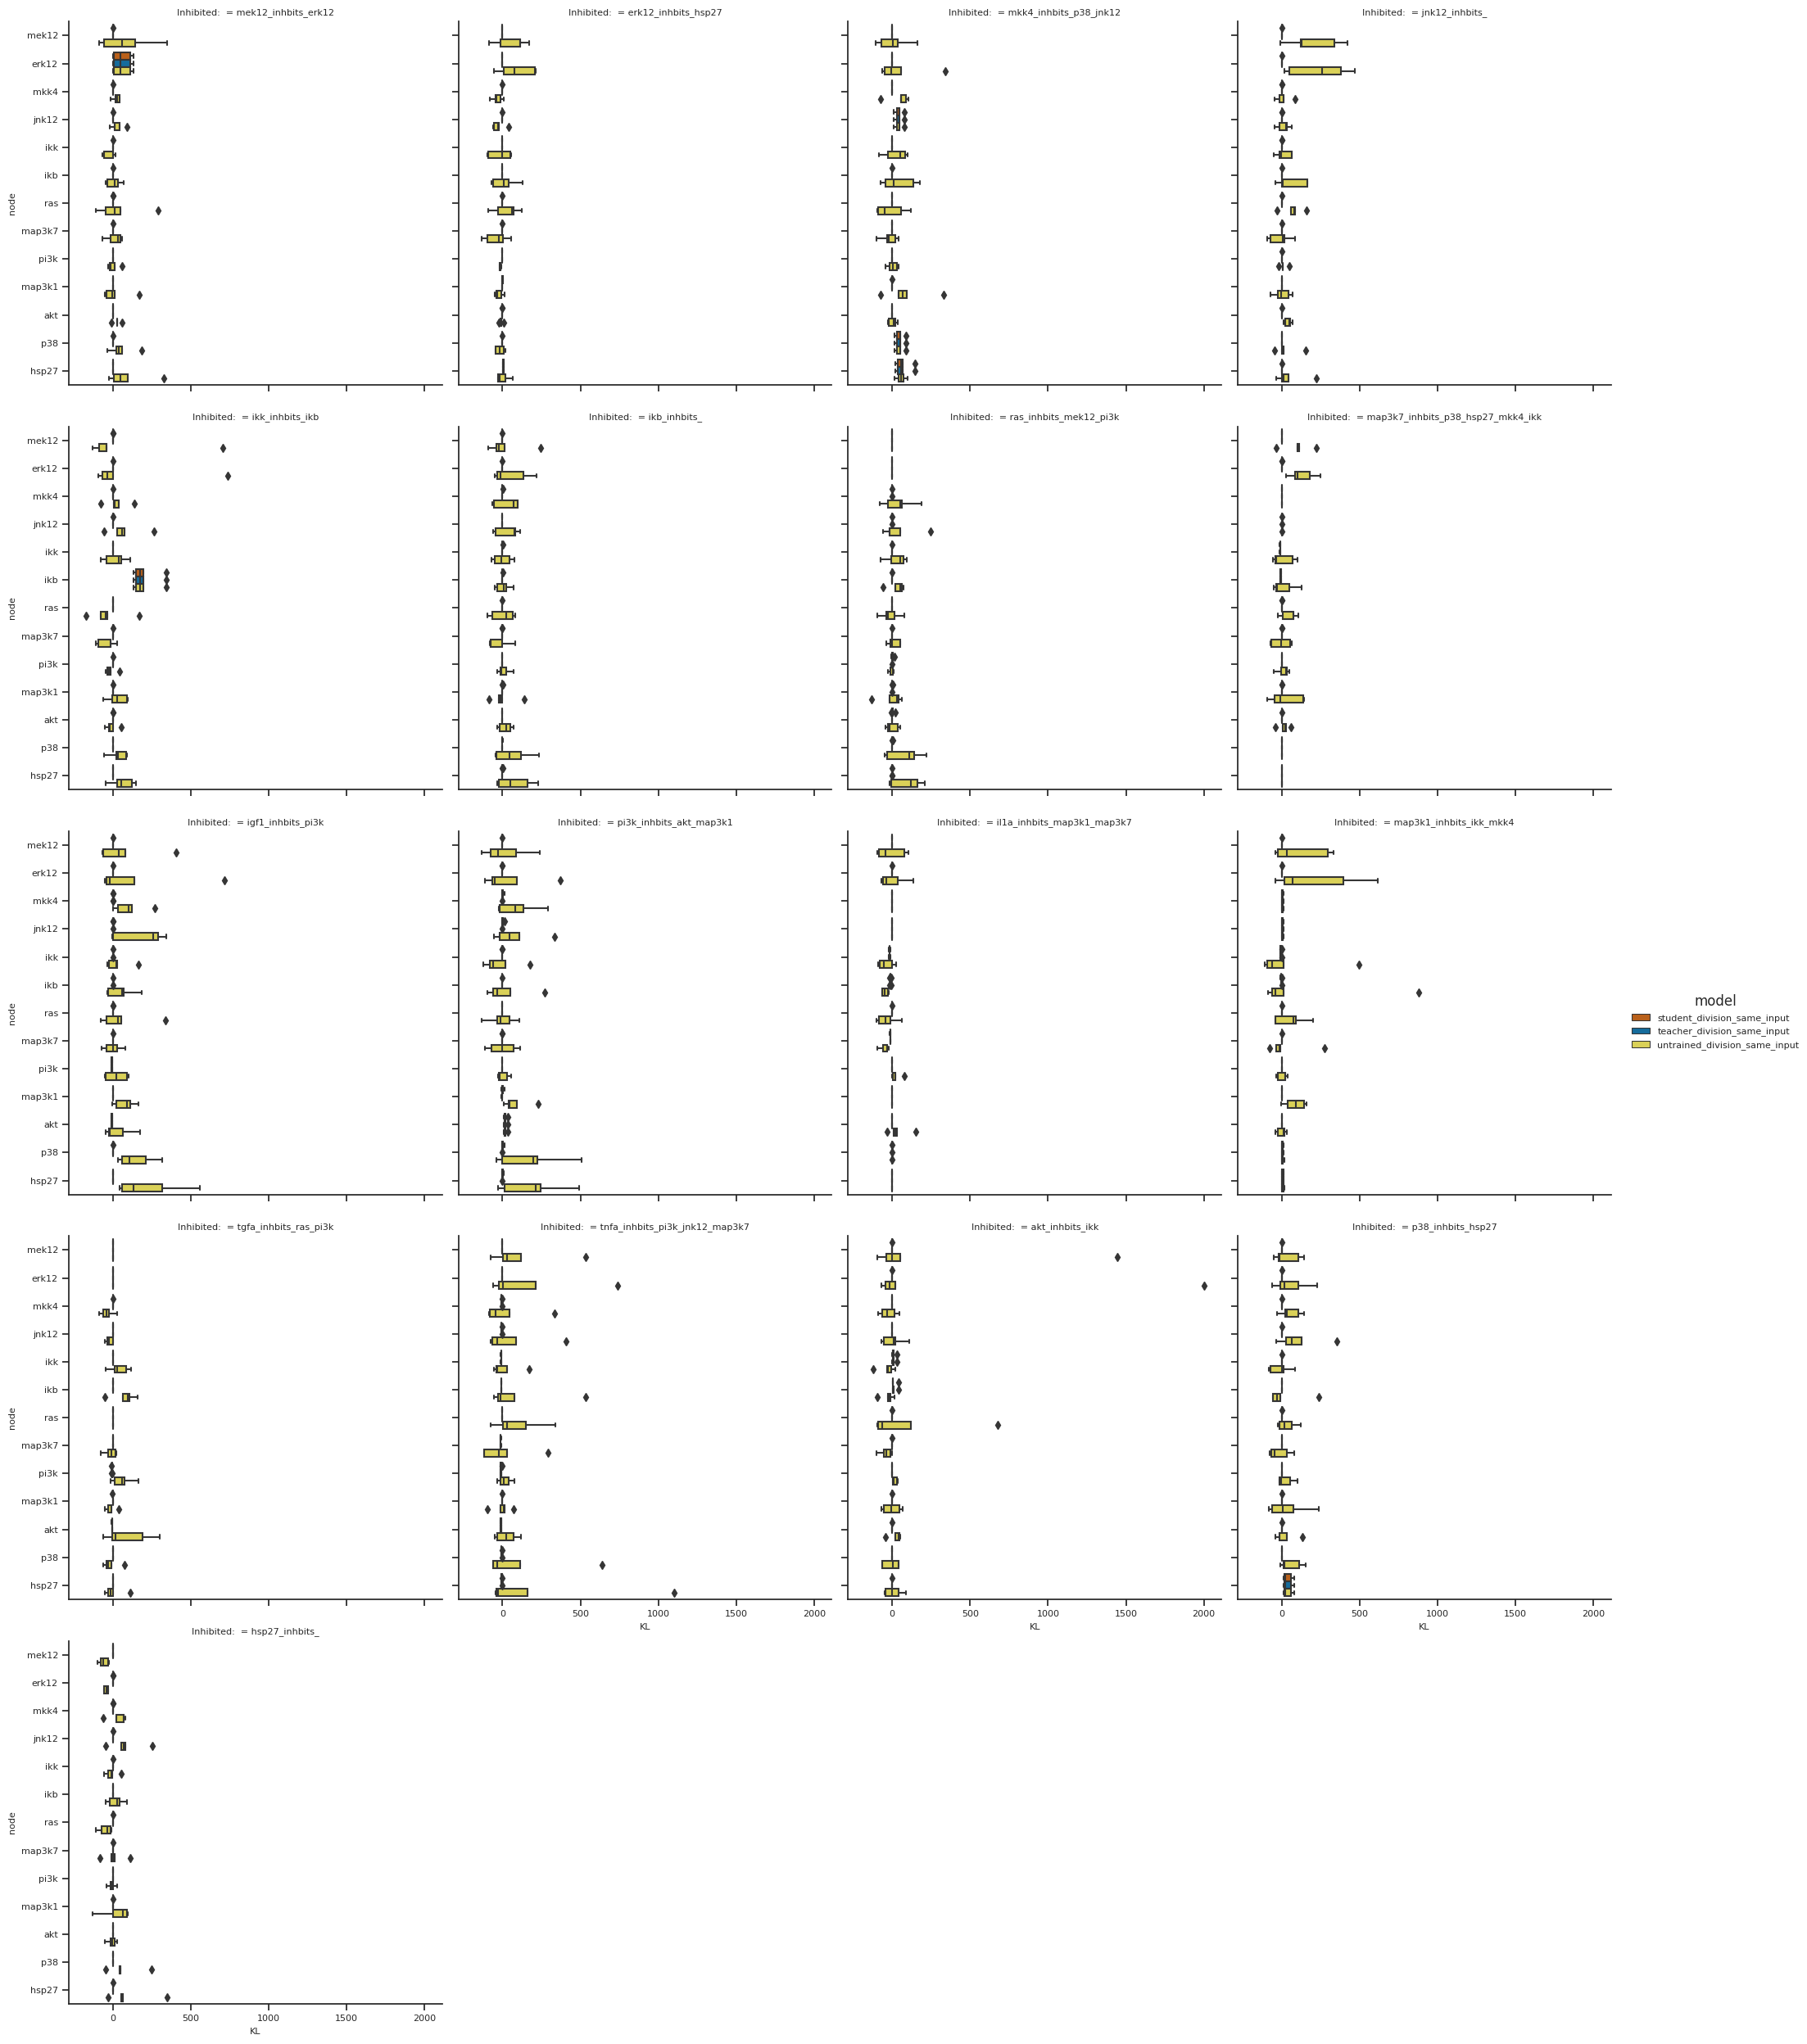

In [25]:
plt_data = perturb_KL[["same" in m for m in perturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="KL")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="KL", col="Inhibited: ", col_wrap=4, kind="box", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_KL_same_inputs.pdf", bbox_inches="tight")
plt.show()

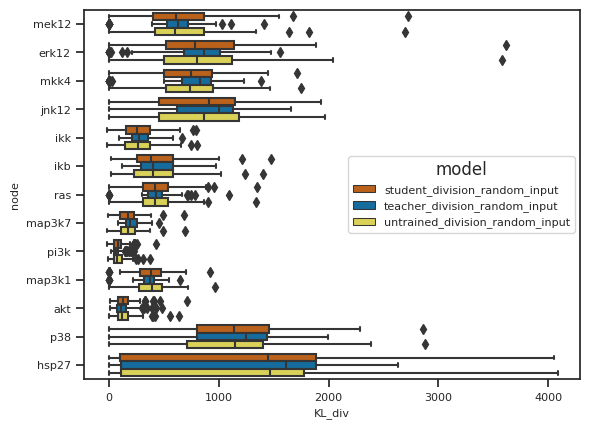

In [26]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_KL[["random" in m for m in unperturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="KL_div")
sns.boxplot(data=plt_data, y="node", x="KL_div", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_KL_random_inputs_no_perturb.pdf", bbox_inches="tight")
plt.show()

# MSE, so matched input

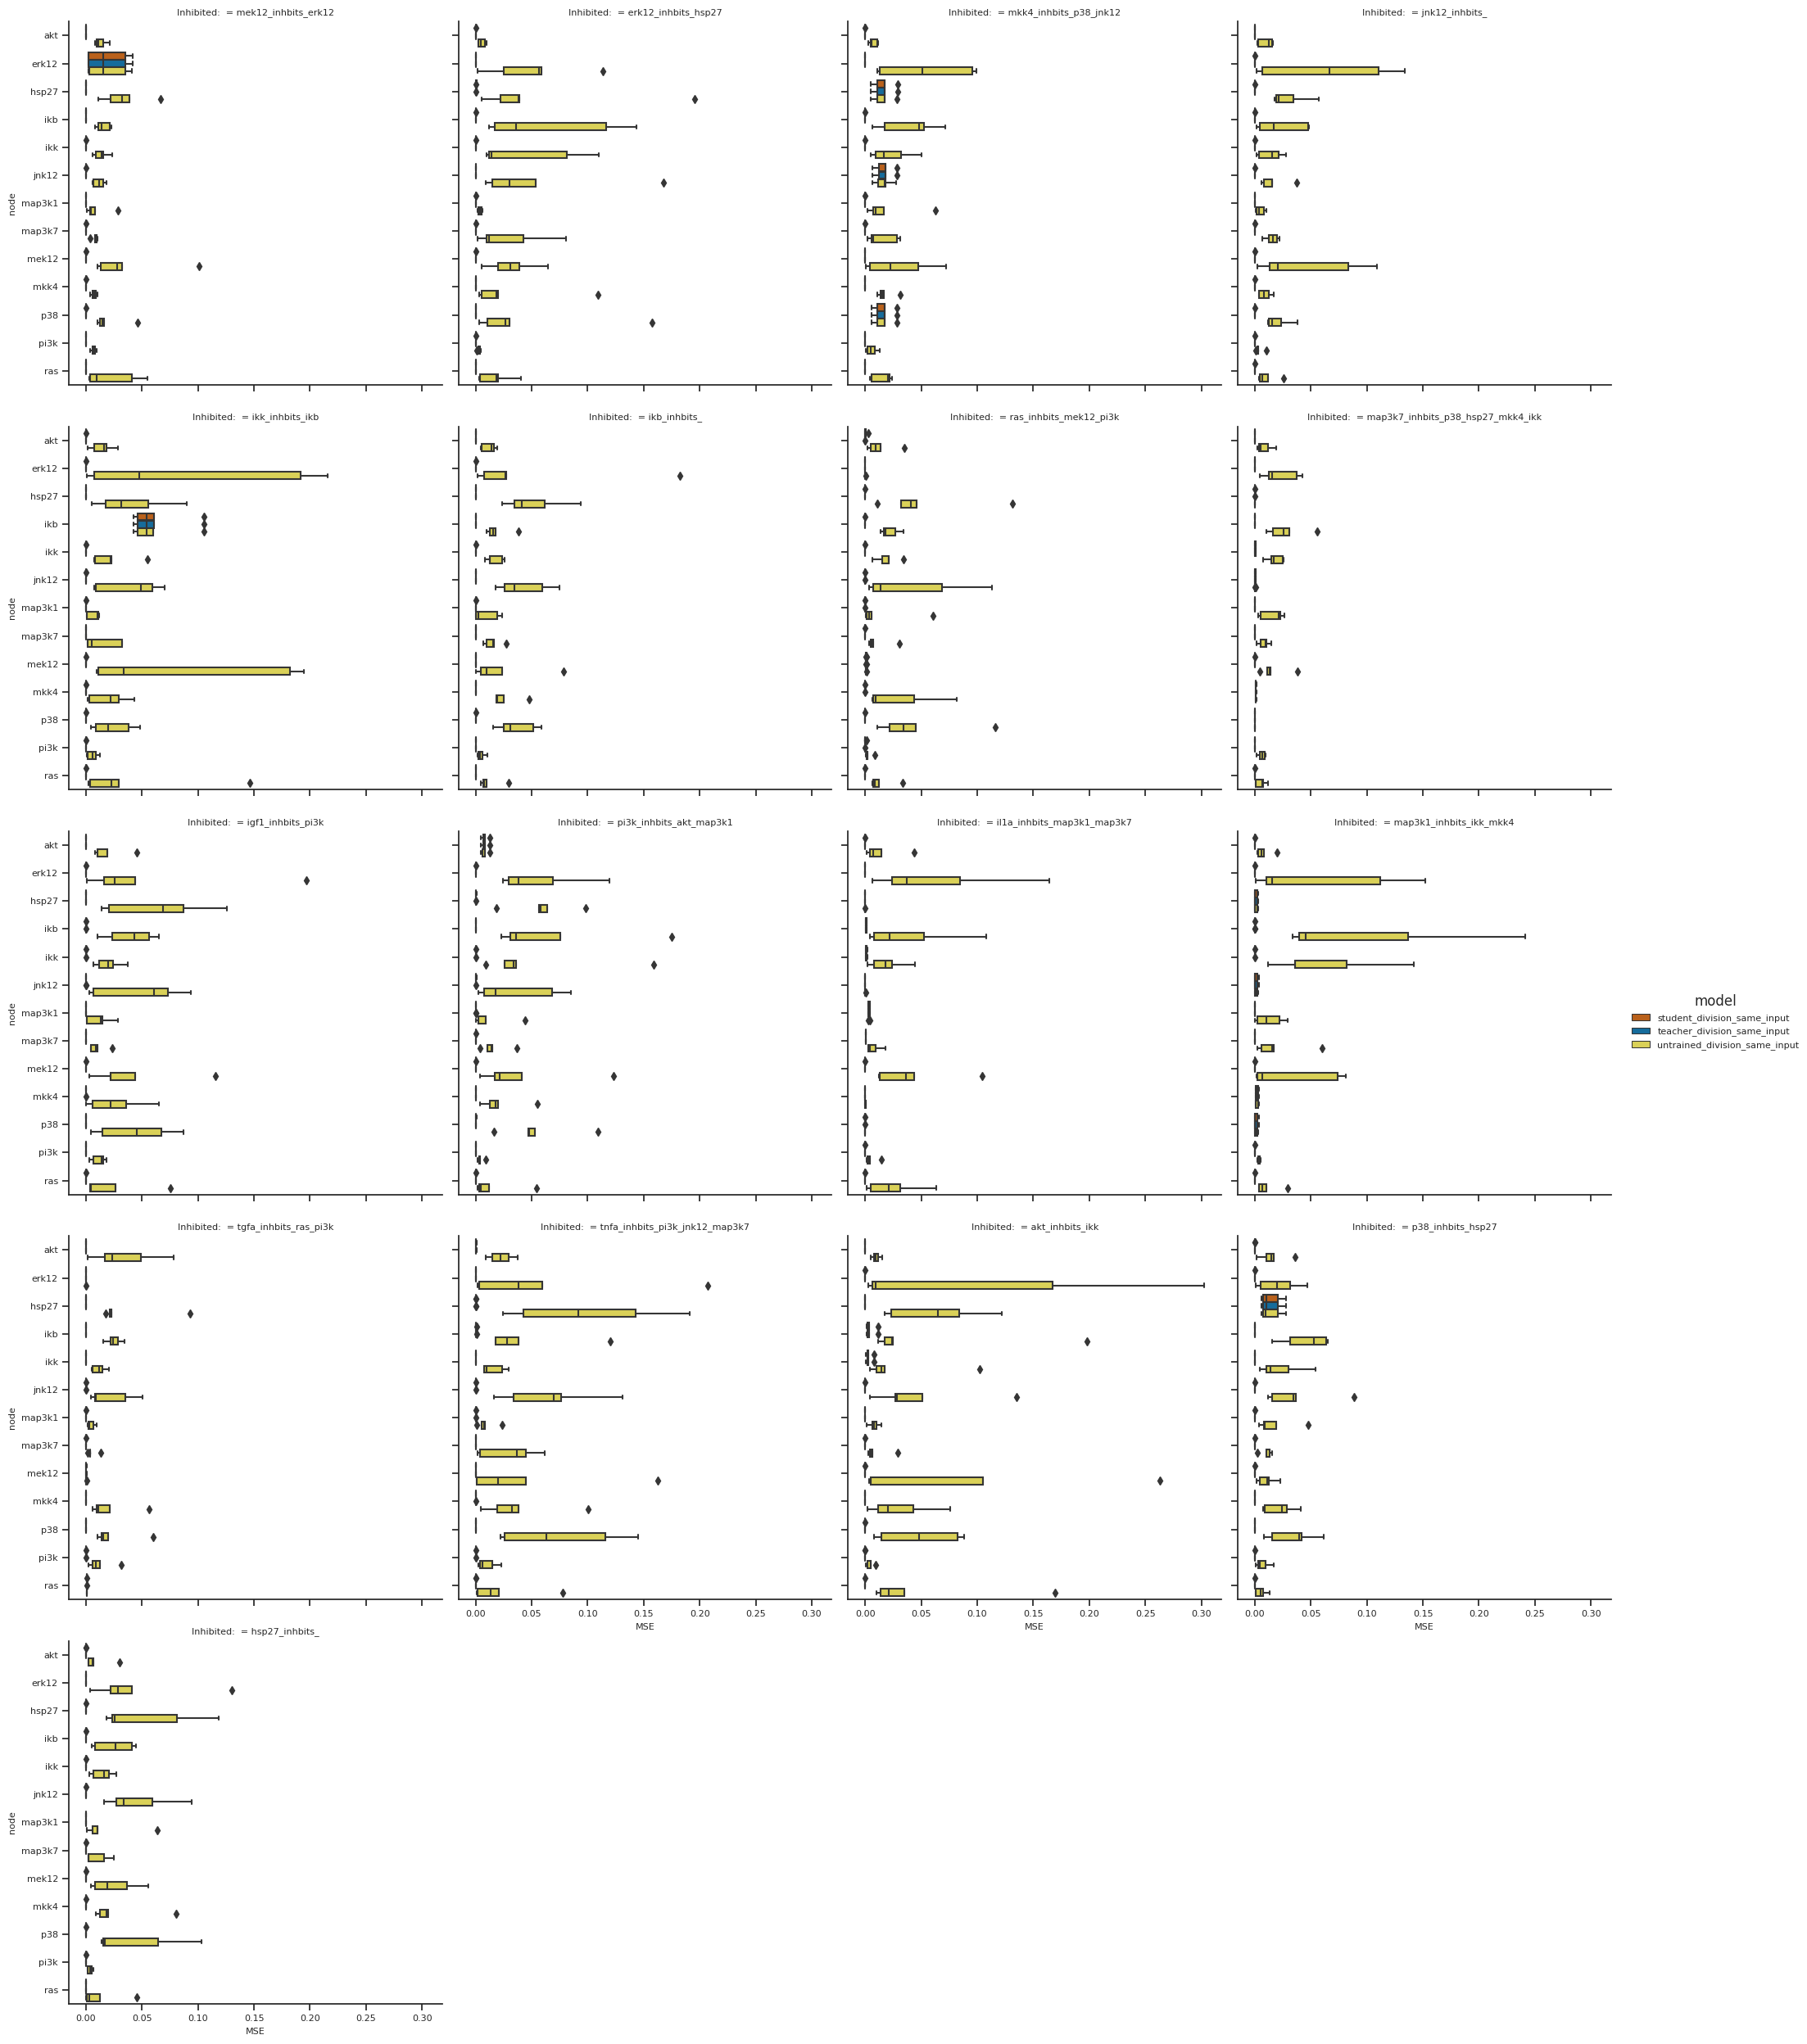

In [27]:
plt_data = perturb_MSE[["same" in m for m in perturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="MSE", col="Inhibited: ", col_wrap=4, kind="box", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs.pdf", bbox_inches="tight")
plt.show()

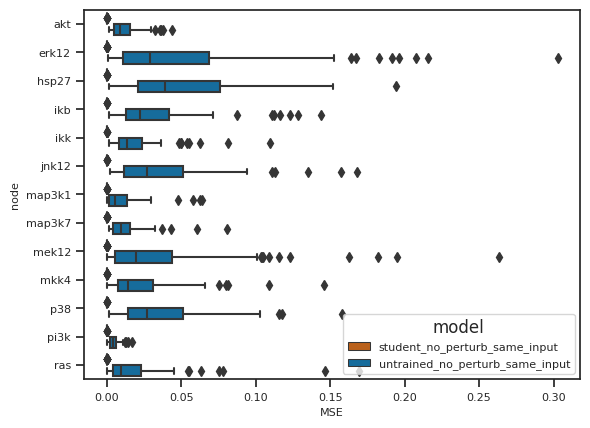

In [28]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_MSE[["same" in m for m in unperturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
sns.boxplot(data=plt_data, y="node", x="MSE", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs_no_perturb.pdf", bbox_inches="tight")
plt.show()

In [29]:
true = perturb_data[perturb_data["model"]=="teacher_k_inhibition_true"]
true = true[true["setting"]==0.0]
true = true[true["repeat"]==0.0]
temp = perturb_data[perturb_data["model"]=="untrained_division_random_input"]
temp = temp[temp["setting"]==0.0]
temp = temp[temp["repeat"]==0.0]

In [30]:
for m in output_markers:
    print(m, r2_score(true[m], temp[m]))

mek12 -0.788034152961995
erk12 -1.028110421391455
mkk4 -1.2620286125351066
jnk12 -1.21398959760588
ikk -0.7855154956322077
ikb -0.8409341330891482
ras -0.8280556228120421
map3k7 -1.0492428442707071
pi3k -1.127577085926645
map3k1 -1.2253146126912506
akt -1.1938315472138985
p38 -1.0689259490251124
hsp27 -1.099629748114646


In [31]:
temp

,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,setting,repeat,inhibited_node,k_value,d_value
0,untrained_division_random_input,0.179566,0.030385,1.000000,1.000000,0.999990,1.000000,0.327182,0.970010,0.614760,0.998719,0.560100,0.998176,9.998839e-01,0.0,0.0,mek12,-100.0,10.0
1,untrained_division_random_input,0.783556,0.099074,0.010030,0.004302,0.503011,0.387052,0.745100,0.377881,0.988721,0.103858,0.999999,0.000264,8.253071e-06,0.0,0.0,mek12,-100.0,10.0
2,untrained_division_random_input,0.268218,0.046658,0.001058,0.000444,0.390087,0.237038,0.417033,0.325895,0.764285,0.017772,0.899820,0.000021,4.671789e-07,0.0,0.0,mek12,-100.0,10.0
3,untrained_division_random_input,0.569689,0.089418,0.003108,0.002237,0.999996,1.000000,0.624096,0.982798,1.000000,0.018003,1.000000,0.000455,3.188380e-05,0.0,0.0,mek12,-100.0,10.0
4,untrained_division_random_input,0.041311,0.006429,0.246973,0.102432,0.801661,0.904905,0.107704,0.427260,0.914851,0.563041,0.997987,0.016980,5.092634e-04,0.0,0.0,mek12,-100.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,untrained_division_random_input,0.228304,0.039339,0.014246,0.005135,0.432427,0.287326,0.379474,0.322086,0.648876,0.173635,0.648811,0.000288,6.130245e-06,0.0,0.0,mek12,-100.0,10.0
996,untrained_division_random_input,0.077850,0.012436,0.000866,0.000359,0.375134,0.220884,0.181096,0.317289,0.683323,0.015432,0.736081,0.000017,3.109958e-07,0.0,0.0,mek12,-100.0,10.0
997,untrained_division_random_input,0.050071,0.007843,0.188059,0.143555,0.967149,0.999323,0.126802,0.729294,0.979168,0.408841,0.999992,0.033262,2.099781e-03,0.0,0.0,mek12,-100.0,10.0
998,untrained_division_random_input,0.693006,0.096752,0.001398,0.000724,0.659282,0.667948,0.693228,0.485967,0.989220,0.011188,0.999999,0.000058,2.453909e-06,0.0,0.0,mek12,-100.0,10.0
